In [160]:
import rasterio as rio
from affine import Affine
from rasterio.crs import CRS
from rasterio.mask import mask
from rasterio.features import shapes, rasterize
import numpy as np

import fiona as fio
import shapely as shp
import geojson

import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

pd.options.display.max_columns = 100
pd.options.display.max_rows = 200

Load and inspect GLODAP data

In [10]:
# In case want to only read partial chunk of the data: 
# https://stackoverflow.com/questions/23853553/python-pandas-how-to-read-only-first-n-rows-of-csv-files-in/23853569
glodap = pd.read_csv("/Users/nathansuberi/Desktop/RW_Data/GLODAPv2 Merged Master File.csv")
print(glodap.shape)
glodap.head(10)

(999448, 101)


,cruise,station,cast,year,month,day,hour,minute,latitude,longitude,bottomdepth,maxsampdepth,bottle,pressure,depth,temperature,theta,salinity,salinityf,salinityqc,sigma0,sigma1,sigma2,sigma3,sigma4,gamma,oxygen,oxygenf,oxygenqc,aou,aouf,nitrate,nitratef,nitrateqc,nitrite,nitritef,silicate,silicatef,silicateqc,phosphate,phosphatef,phosphateqc,tco2,tco2f,tco2qc,talk,talkf,talkqc,phts25p0,phts25p0f,...,phtsinsitutpf,phtsqc,cfc11,pcfc11,cfc11f,cfc11qc,cfc12,pcfc12,cfc12f,cfc12qc,cfc113,pcfc113,cfc113f,cfc113qc,ccl4,pccl4,ccl4f,ccl4qc,sf6,psf6,sf6f,c13,c13f,c14,c14f,c14err,h3,h3f,h3err,he3,he3f,he3err,he,hef,heerr,neon,neonf,neonerr,o18,o18f,toc,tocf,doc,docf,don,donf,tdn,tdnf,chla,chlaf
0,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,1,8.6,9.0,0.4049,0.404588,33.381,2,1,26.7784,31.4886,36.0930,40.5929,44.9899,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,...,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
1,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,2,8.6,9.0,0.5369,0.536580,33.249,2,1,26.6648,31.3723,35.9739,40.4712,44.8658,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,...,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
2,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,3,48.9,48.0,2.3604,2.357680,34.806,2,1,27.7870,32.4295,36.9677,41.4034,45.7384,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,...,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
3,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,4,48.9,48.0,2.3614,2.358680,34.803,2,1,27.7845,32.4270,36.9652,41.4009,45.7359,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,...,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
4,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,5,148.0,146.0,2.4664,2.457870,34.981,2,1,27.9185,32.5568,37.0909,41.5226,45.8538,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,...,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
5,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,6,148.0,146.0,2.4724,2.463860,34.986,2,1,27.9220,32.5601,37.0940,41.5255,45.8565,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,...,9,1,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,0,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,1,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,-9999.0,9.0,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9,-9999.0,9
6,1,319.0,1,1984,7,20,14,46,80.5667,7.2267,733.0,724.0,7,148.0,146.0,2.4684,2.459870,34.981,2,1,27.9183,32.5565,37.0906,41.5223,45.8534,-9999.0,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-9999.0,9,1,-

Use groupby to break data apart by year

In [28]:
# Trim GLODAP data for experimentation
glodap_trim = glodap[["year", "latitude", "longitude", "depth", "pressure", "temperature"]]
glodap_trim_grouped = glodap_trim.groupby("year")

# Show number of observations per year
glodap_trim_grouped.count()

,latitude,longitude,depth,pressure,temperature
year,,,,,
1972,4416,4416,4416,4416,4416
1973,5789,5789,5789,5789,5789
1974,4898,4898,4898,4898,4898
1977,1576,1576,1576,1576,1576
1978,2443,2443,2443,2443,2443
1980,4961,4961,4961,4961,4961
1981,12528,12528,12528,12528,12528
1982,4188,4188,4188,4188,4188
1983,9209,9209,9209,9209,9209


In [42]:
# Inspect groupby structure, and accessing first year of data
years = list(glodap_trim_grouped.groups.keys())
print(years)
#print(glodap_trim_grouped.groups)
print(glodap_trim_grouped.get_group(years[0]))

[1972, 1973, 1974, 1977, 1978, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013]
        year  latitude  longitude   depth  pressure  temperature
255619  1972    44.950    -42.002     1.0       1.0       21.660
255620  1972    44.950    -42.002    16.0      16.0       21.640
255621  1972    44.950    -42.002    31.0      31.0       16.380
255622  1972    44.950    -42.002    48.0      48.0       12.690
255623  1972    44.950    -42.002    89.0      90.0       12.730
255624  1972    44.950    -42.002   123.0     124.0       12.051
255625  1972    44.950    -42.002   157.0     158.0       11.155
255626  1972    44.950    -42.002   188.0     189.0       10.490
255627  1972    44.950    -42.002   240.0     242.0       10.117
255628  1972    44.950    -42.002   286.0     288.0        9.480
255629  1972    44.950    -42.002   380.0     383.

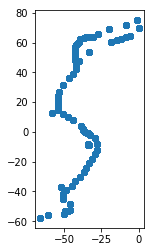

In [172]:
# Store first available year of data
data_1972 = glodap_trim_grouped.get_group(years[0])

# Use latitude and longitude columns to create a GeoDataFrame, add CRS

geometry = [shp.geometry.Point(xy) for xy in zip(data_1972["longitude"], data_1972["latitude"])]
data_1972 = data_1972.drop(['longitude', 'latitude'], axis=1)

crs = {'init': 'epsg:4326'}
geodata_1972 = gpd.GeoDataFrame(data_1972, crs=crs, geometry=geometry)

# Display points
geodata_1972.plot()

In [57]:
# World country boundaries for context
country_bounds = gpd.read_file("/Users/nathansuberi/Downloads/all_countries/all_countries.shp")
country_bounds = country_bounds[["geometry", "name"]]

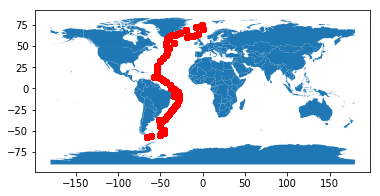

In [62]:
### Q: How to add this into a world map?
# http://geopandas.org/mapping.html
# See bottom for two methods
base = country_bounds.plot()
geodata_1972.plot(ax=base, marker="o", color="red")

Create a base raster to overlay the vector data into

In [145]:
# Create 1 degree raster

def create_transform(row_width,row_rotation, upper_right_x,
                    column_rotation, column_height, upper_right_y):
    
    return(Affine(row_width,row_rotation,upper_right_x,
                  column_rotation, column_height, upper_right_y))

degree1 = create_transform(1,0,-180,0,-1,90)

# Create array of ones size of a global, 1 degree raster
dst_array = np.ones((360, 180), dtype=np.float32)
#dst_array = np.random.randn(360, 180).astype(np.float32)
#print(dst_array)

# Use rasterio to classify this as WGS84 EPSG:4326
world_array = '/Users/nathansuberi/Desktop/RW_Data/world_array.tif'

profile = {
    'driver': 'GTiff', 
    'dtype': np.float32, 
    'nodata': 0, 
    'width': 360, 
    'height': 180, 
    'count': 1, 
    'crs': CRS({'init': 'EPSG:4326'}), 
    'transform':degree1,
    'blockxsize': 128, 
    'blockysize': 128, 
    'tiled': True, 
    'compress': 'lzw', 
    'interleave': 'band'
}
with rio.open(world_array, "w", **profile) as dst:
    dst.write(dst_array, indexes=1)

# Print, observe
with rio.open(world_array, "r") as src:
    world_data = src.read(indexes=1)
    #print(src.profile)
    #print(data)

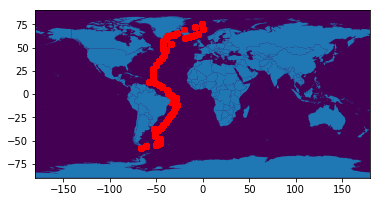

In [96]:
# View raster with vector features over top
# Using plt.gca(): https://gis.stackexchange.com/questions/193653/plot-shapefile-on-top-of-raster-using-plot-and-imshow-from-matplotlib?rq=1
# Setting extent, from Logan's response: https://gis.stackexchange.com/questions/251396/graph-points-in-image-using-matplotlib

# Raster data
# Extent parameter is necessary here for alignment
plt.imshow(world_data, extent = [-180, 180, -90, 90])

# Get current axes
ax = plt.gca()

# Use these axes to plot the vector data
geodata_1972.plot(ax=ax, marker="o", color="red")
country_bounds.plot(ax=ax)

(1, 180, 360)
(180, 360)
[[0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 [0.0 0.0 0.0 ..., 0.0 0.0 0.0]
 ..., 
 [-9999.0 -9999.0 -9999.0 ..., -9999.0 -9999.0 -9999.0]
 [-9999.0 -9999.0 -9999.0 ..., -9999.0 -9999.0 -9999.0]
 [-9999.0 -9999.0 -9999.0 ..., -9999.0 -9999.0 -9999.0]]


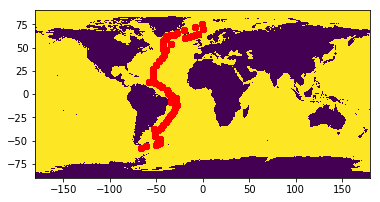

In [105]:
# Mask out all land values

with fio.open("/Users/nathansuberi/Desktop/RW_Data/all_countries/all_countries.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]
    
# https://stackoverflow.com/questions/41462999/how-do-i-use-rasterio-python-to-mask-a-raster-using-a-shapefile-to-set-the-rast
with rio.open(world_array, "r") as src:
    out_image, out_transform = mask(src, geoms, crop=False, invert=True)
    out_meta = src.meta.copy()

# Need to squeeze the image so that it becomes only 2 dimensions, 
# instead of having a first "band" dimension
print(out_image.shape)
out_image = np.squeeze(out_image)
print(out_image.shape)
  
out_image[out_image==0] = -9999
out_image[out_image==1] = 0

print(out_image)
plt.imshow(out_image, extent=[-180, 180, -90, 90])

ax = plt.gca()

# Use these axes to plot the vector data
geodata_1972.plot(ax=ax, marker="o", color="red")

In [108]:
# Review geodata_1972 structure
geodata_1972.head()

,year,depth,pressure,temperature,geometry
255619,1972,1.0,1.0,21.66,POINT (-42.002 44.95)
255620,1972,16.0,16.0,21.64,POINT (-42.002 44.95)
255621,1972,31.0,31.0,16.38,POINT (-42.002 44.95)
255622,1972,48.0,48.0,12.69,POINT (-42.002 44.95)
255623,1972,89.0,90.0,12.73,POINT (-42.002 44.95)


| 1.00, 0.00,-180.00|
| 0.00,-1.00, 90.00|
| 0.00, 0.00, 1.00|
        0       1       2       3       4       5       6       7       8   \
0  -9999.0 -9999.0 -9999.0 -9999.0 -9999.0 -9999.0     0.0     0.0     0.0   
1  -9999.0 -9999.0 -9999.0 -9999.0 -9999.0     0.0     0.0     0.0     0.0   
2  -9999.0 -9999.0 -9999.0 -9999.0     0.0     0.0     0.0     0.0     0.0   
3  -9999.0 -9999.0 -9999.0 -9999.0     0.0     0.0     0.0     0.0     0.0   
4  -9999.0 -9999.0 -9999.0 -9999.0     0.0     0.0     0.0     0.0     0.0   
5  -9999.0 -9999.0 -9999.0     0.0     0.0     0.0     0.0     0.0     0.0   
6  -9999.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
7      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
8      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
9      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
10     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1

(180, 360)

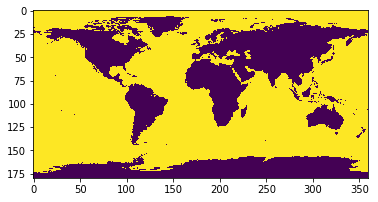

In [141]:
# Overlay GLODAP data with the raster

shapes = ((geom,value) for geom, value in zip(geodata_1972["geometry"], geodata_1972["temperature"]))

print(out_transform)

image = rasterize(
            shapes,
            out=out_image,
            out_shape=out_image.shape,
            transform=out_transform,
            all_touched=True,
            dtype=np.float32,
            default_value=10,
            fill=10)

# This is working!
print(pd.DataFrame(image[50:100, 100:150]))
plt.imshow(image)
image.shape

In [185]:
# Calculate average value for each raster cell

# Bin data by lat-long squares
# Could create a polygon "raster": https://gis.stackexchange.com/questions/54119/creating-square-grid-polygon-shapefile-with-python
# And then burn into a raster of same extent

# -OR-

# Can fill world_data with unique values to force creation of separate
rows, cols = world_data.shape
for r in range(rows):
    for c in range(cols):
        world_data[r,c] = r*rows+c

features, _ = zip(*shapes(world_data, transform=degree1))
features = [geojson.Feature(geometry=feature) for feature in features]        
#print(features)

crs = {'init': 'epsg:4326'}
vector_raster_grid = gpd.GeoDataFrame.from_features(features, crs=crs)

observations_per_grid = gpd.sjoin(vector_raster_grid, geodata_1972, how="left", op="intersects")

In [188]:
#geodata_1972.head()
#vector_raster_grid.head()
observations_per_grid.dropna(axis=0)

,geometry,index_right,year,depth,pressure,temperature
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256410.0,1972.0,351.0,355.0,-1.118
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256409.0,1972.0,350.0,353.0,-1.130
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256408.0,1972.0,306.0,309.0,-1.100
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256407.0,1972.0,303.0,306.0,-1.215
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256406.0,1972.0,254.0,257.0,-1.318
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256419.0,1972.0,883.0,894.0,-1.074
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256463.0,1972.0,3516.0,3582.0,-1.110
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256404.0,1972.0,230.0,232.0,-1.410
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256403.0,1972.0,202.0,204.0,-1.521
5578,"POLYGON ((-2 75, -2 74, -1 74, -1 75, -2 75))",256402.0,1972.0,180.0,181.0,-1.400


Experimental

     0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
11  0.0  0.0  0.0  0.0  0.0 

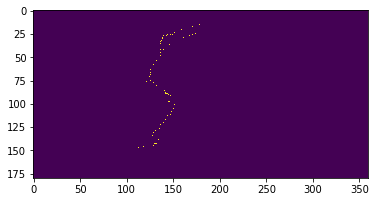

In [139]:
#geodata_1972.to_file(driver = 'GeoJSON', filename= "points.json")
#!rio rasterize points.json test_rasterize.tif --like '/Users/nathansuberi/Desktop/RW_Data/world_array.tif'

# with rio.open("test_rasterize.tif", "r") as src:
#     data = src.read(indexes=1)

# # Just shows a 1 / 0 for whether it intersects... doesn't carry over data
# print(pd.DataFrame(data[50:100, 100:150]))
# plt.imshow(data)